## Загрузка данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import random
import seaborn as sns
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/6_class.csv', index_col='Unnamed: 0')

## Предобработка и анализ данных

In [3]:
df

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red
...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,Blue
236,30839,834042.000000,1194.0000,-10.63,5,Blue
237,8829,537493.000000,1423.0000,-10.73,5,White
238,9235,404940.000000,1112.0000,-11.23,5,White


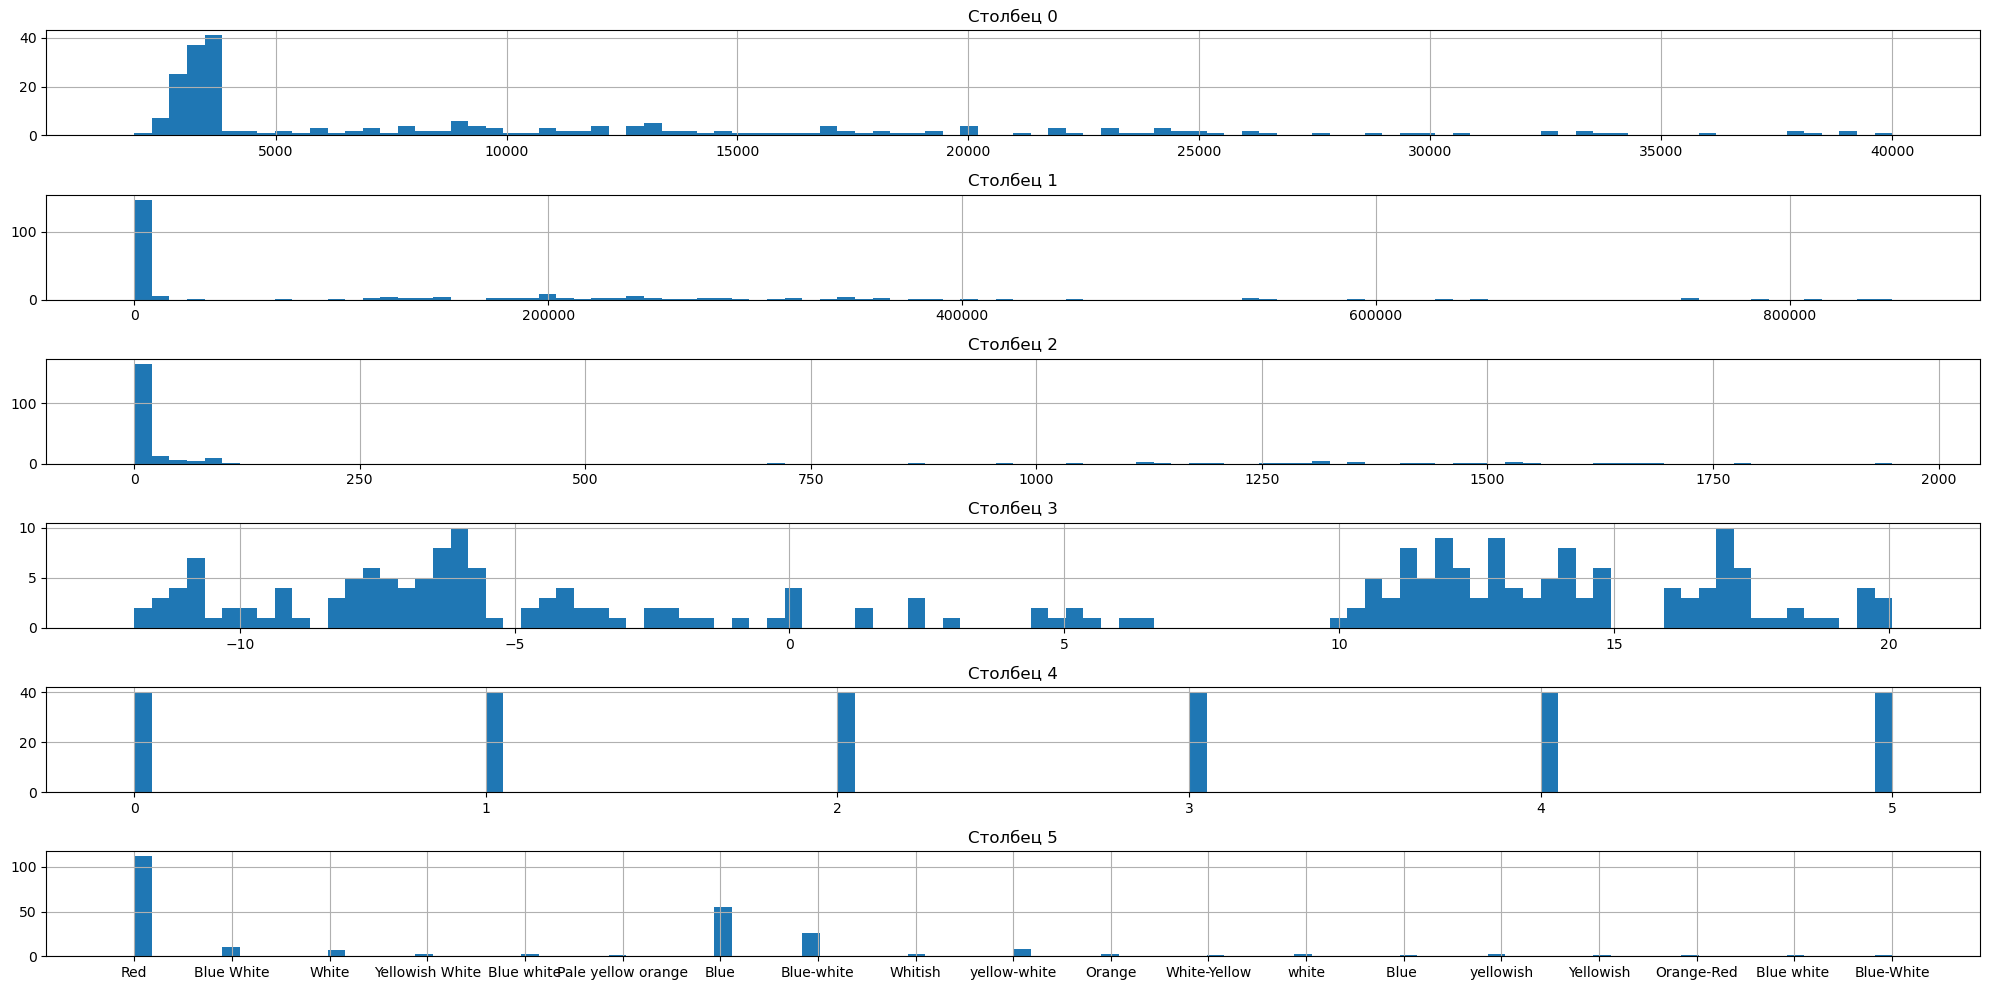

In [4]:
num_columns = df.shape[1]
num_rows = 6
num_cols = 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

for i, ax in enumerate(axes.flat):
    if i < num_columns:
        df.iloc[:, i].hist(bins=100, ax=ax)
        ax.set_title(f'Столбец {i}')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [5]:
df['Star color'] = OrdinalEncoder().fit_transform(df[['Star color']])

In [6]:
y = df["Temperature (K)"]
X = df.drop("Temperature (K)", axis=1)

In [7]:
scaler = StandardScaler()
columns_X = X.columns
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=columns_X)

del scaler
del columns_X

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [10]:
X_train_tensor = torch.FloatTensor(X_train.values) 
X_test_tensor = torch.FloatTensor(X_test.values)
y_train_tensor = torch.FloatTensor(y_train.values)
y_test_tensor = torch.FloatTensor(y_test.values)

## Построение базовой нейронной сети

In [11]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

In [12]:
num_epochs = 500
learning_rate = 0.07

In [13]:
def init_weights(layer):
    
    if type(layer) == nn.Linear: 
        nn.init.normal_(layer.weight, mean= 0.0, std=1.14)
        nn.init.normal_(layer.bias, mean=-0.5, std=1.0) 

In [14]:
results_loss_1 = [] 
results_time_1 = [] 
results_loss_2 = [] 

n_in_neurons = X_train_tensor.shape[1]
n_hidden_neurons_1 = 10
n_hidden_neurons_2 = 10
n_out_neurons = 1 

net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ELU(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ELU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons),
    nn.ReLU()
)

net.apply(init_weights)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss = nn.MSELoss()

In [15]:
for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()
    preds = net.forward(X_train_tensor).flatten()
     
    loss_value = loss(preds, y_train_tensor)
    loss_value.backward()
    optimizer.step()

    if epoch % 10 == 0 or epoch == num_epochs - 1:
        with torch.no_grad():   
                net.eval()
                test_preds = net.forward(X_test_tensor).flatten()
                loss_value_test = loss(test_preds, y_test_tensor) 
                print('epoch {}, RMSE train {:.4f}, RMSE test {:.4f}'.format(epoch, torch.Tensor.sqrt_(loss_value),\
                                                                             torch.Tensor.sqrt_(loss_value_test)))                
              
                results_loss_1.append(loss_value.tolist())
                results_time_1.append(epoch)
                results_loss_2.append(loss_value_test.tolist())
                
       
print('')
print('Лучшее значение RMSE train: ', min(results_loss_1))
print('Лучшее значение RMSE test: ', min(results_loss_2))

epoch 0, RMSE train 14026.9756, RMSE test 14624.7783
epoch 10, RMSE train 13998.9307, RMSE test 14590.4570
epoch 20, RMSE train 13887.0264, RMSE test 14457.3438
epoch 30, RMSE train 13543.8320, RMSE test 14056.0850
epoch 40, RMSE train 12736.4434, RMSE test 13140.3408
epoch 50, RMSE train 11309.7432, RMSE test 11612.0811
epoch 60, RMSE train 9566.4102, RMSE test 9961.6523
epoch 70, RMSE train 8164.0415, RMSE test 8691.9102
epoch 80, RMSE train 7200.6812, RMSE test 7964.6714
epoch 90, RMSE train 6612.3530, RMSE test 7448.1958
epoch 100, RMSE train 6246.6543, RMSE test 7094.7109
epoch 110, RMSE train 6038.5698, RMSE test 6888.3701
epoch 120, RMSE train 5905.5396, RMSE test 6738.1167
epoch 130, RMSE train 5806.3145, RMSE test 6591.3540
epoch 140, RMSE train 5715.6621, RMSE test 6439.8496
epoch 150, RMSE train 5630.7349, RMSE test 6309.6895
epoch 160, RMSE train 5528.5210, RMSE test 6183.0190
epoch 170, RMSE train 5410.6743, RMSE test 6044.1587
epoch 180, RMSE train 5287.2783, RMSE test 58

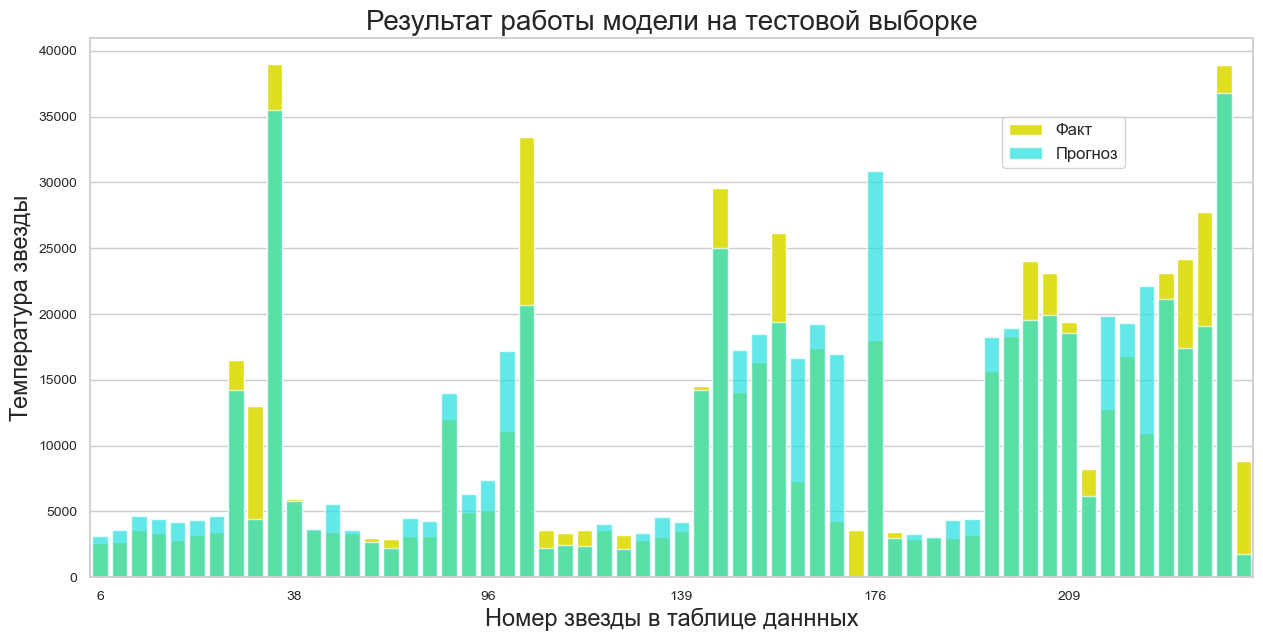

In [17]:
x = pd.concat([y_test.reset_index(), pd.Series(test_preds.flatten().detach().numpy())], axis=1)

sns.set(style="whitegrid")
fig_1=plt.figure(1, figsize=(15, 7))


sns.barplot(data=x, x='index', y='Temperature (K)', color ='yellow', alpha = 1, label='Факт')
sns.barplot(data=x, x='index', y=0, color ='cyan', alpha = 0.7, label='Прогноз')

plt.xticks(ticks=np.arange(0, len(x), 10), fontsize=10)
plt.yticks(fontsize=10)
plt.legend(bbox_to_anchor=(0.897,0.87), prop={'size':12})
plt.xlabel('Номер звезды в таблице даннных', fontsize=17)
plt.ylabel('Температура звезды', fontsize=17)
plt.title('Результат работы модели на тестовой выборке', fontsize=20)
plt.draw()

## Улучшение нейронной сети

## Выводы